In [42]:
# import load_iris function from datasets module
from sklearn.datasets import load_iris
from sklearn import metrics
from sklearn.metrics import f1_score
import csv
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA # Principal Component Analysis module
from sklearn.cluster import KMeans # KMeans clustering 
import matplotlib.pyplot as plt # Python defacto plotting library
import seaborn as sns # More snazzy plotting library
%matplotlib inline 
from gensim.models import word2vec
from sklearn import svm
from sklearn import ensemble
from sklearn.feature_selection import RFE

In [43]:
#Load csv data
with open("movie_metadata.csv", 'rb') as f:
    raw_data = list(csv.reader(f))
        

In [44]:
#clean the dataset by ignoring it if any column is empty or equal to 0

data = []
counter = 0
for row in raw_data:
    qualified = True
    for column in row:
        if column == " "or column == 0 or column =="0":
            qualified = False
    if qualified:
        data.append(row)
    counter = counter + 1

In [45]:
movie = pd.read_csv('movie_metadata.csv') # reads the csv and creates the dataframe called movie
movie.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [46]:
#plot_keywords -> numerical values
#dictioinarize the plot keywords section with their corresponding imdb_score
plot_keywords_dic = {}
for index, row in movie.iterrows():
    words_array = str(row["plot_keywords"]).split("|")
    for word in words_array:
        if word not in plot_keywords_dic:
            plot_keywords_dic[word] = []
        plot_keywords_dic[word].append(row["imdb_score"])

#compute the average of all the plot keywords in the dictionary
for key, elem in plot_keywords_dic.items():
    plot_keywords_dic[key] = sum(elem)/len(elem)

        
#convert the orignal movie value to the sum of the top five keywords foundable in the training dataset
for index, row in movie.iterrows():
    words_array = str(row["plot_keywords"]).split("|")
    plot_value = 0
    counter = 0
    i = 0
    while counter < 5 and i < len(words_array):
        if(words_array[i] in plot_keywords_dic):
            plot_value = plot_value + plot_keywords_dic[words_array[i]]
            counter = counter + 1
        i = i + 1
    movie.set_value(index,'plot_keywords',plot_value)
    

#Genres -> Column Feature
genre_list = []
for index, row in movie.iterrows():
    words_array = str(row["genres"]).split("|")
    for word in words_array:
        if word not in genre_list:
            genre_list.append(word)
            
for movie_genre in genre_list:
    movie[movie_genre] = pd.Series(0,index=movie.index)
    
#convert the orignal movie value to the sum of the top five keywords foundable in the training dataset
for index, row in movie.iterrows():
    words_array = str(row["genres"]).split("|")
    for word in words_array:
        movie.set_value(index,word,1)
    

#Country -> Index
country_dic = {}
for index, row in movie.iterrows():
    word = str(row["country"])
    if word not in country_dic:
        country_dic[word] = [1]
        
country_index = 1
#assign each country an index number
for key, elem in country_dic.items():
    country_dic[key] = country_index
    country_index = country_index+1
    
for index, row in movie.iterrows():
    word = str(row["country"])
    movie.set_value(index,'country',country_dic[word])
    

In [47]:
# converting director_name, actor1_name, actor2_name, actor3_name, content rating, and language to numeric values
director_map = {}
count = 0
for name in movie["director_name"]:
    if not director_map.has_key(str(name)):
        #dict[str(name)] = count
        director_map.update({str(name): count})
        count+=1
#print director_map

# converting actor1 to values
actors_map = {}
actors_count = 0

tempActors = movie["actor_1_name"].copy(True);
pd.np.random.shuffle(tempActors)
#for name in movie["actor_1_name"]:
for name in tempActors:
    #print name
    if not actors_map.has_key(str(name)):
        actors_map.update({str(name): actors_count})
        actors_count+=1

# converting actor2 to values
tempActors = movie["actor_2_name"].copy(True);
pd.np.random.shuffle(tempActors)
#for name in movie["actor_2_name"]:
for name in tempActors:
    if not actors_map.has_key(str(name)):
        actors_map.update({str(name): actors_count})
        actors_count+=1
        
tempActors = movie["actor_3_name"].copy(True);
pd.np.random.shuffle(tempActors)
# converting actor3 to values
#for name in movie["actor_3_name"]:
for name in tempActors:
    if not actors_map.has_key(str(name)):
        actors_map.update({str(name): actors_count})
        actors_count+=1
        
rating_map = {}
rating_count = 0
for rating in movie["content_rating"]:
    if not str(rating) in rating_map:
        rating_map.update({str(rating): rating_count})
        rating_count+=1
        #print rating
        
language_map = {}
language_count = 0
for language in movie["language"]:
    if not str(language) in language_map:
        language_map.update({str(language): language_count})
        language_count+=1
        
for index, row in movie.iterrows():
    movie.set_value(index, 'director_name', director_map[str(row['director_name'])])
    movie.set_value(index, 'actor_1_name', actors_map[str(row['actor_1_name'])])
    movie.set_value(index, 'actor_2_name', actors_map[str(row['actor_2_name'])])
    movie.set_value(index, 'actor_3_name', actors_map[str(row['actor_3_name'])])    
    movie.set_value(index, 'language', language_map[str(row['language'])])
    movie.set_value(index, 'content_rating', rating_map[str(row['content_rating'])])
    
movie.head()

str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in movie.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
    
#include the column name if applicable 
str_list.append("imdb_score")
            

# Get to the numeric columns by inversion            
num_list = movie.columns.difference(str_list)  

In [48]:
movie_num = movie[num_list]
#del movie # Get rid of movie df as we won't need it now
#movie_num.head()

#Remove some existing features generated after the movie is screening
del movie_num['gross']
del movie_num['num_critic_for_reviews']
del movie_num['num_user_for_reviews']

In [49]:
movie_num = movie_num.fillna(value=0, axis=1)
X = movie_num.values
#print movie_num.head()
# Data Normalization
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

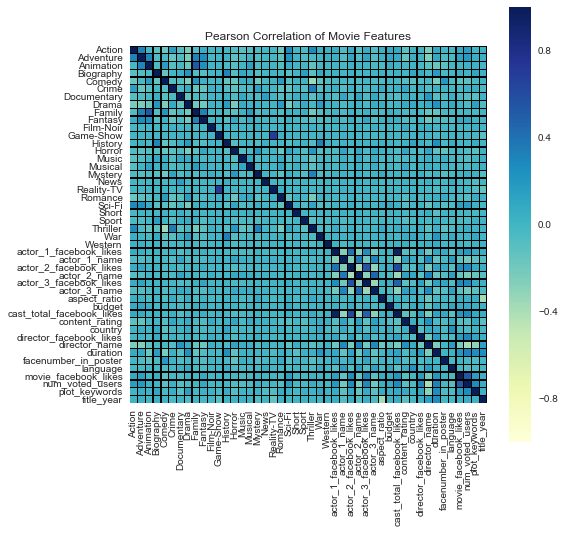

In [50]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
plt.title('Pearson Correlation of Movie Features')
# Draw the heatmap using seaborn
sns.heatmap(movie_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black')

#Pearson Correlation shows how does each variable corelate to each other
#1 means totally linear correlation, 0 means no correlation and -1 means totally negative linear correlation

In [51]:
#explained variance measure
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [52]:
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance
#print cum_var_exp

In [53]:
#PCA

pca = PCA(n_components=9)
x_9d = pca.fit_transform(X_std)

#x_9d is the dataset that contains the PCA(9) of the movie variable data

In [54]:
# make 5 folds
print len(movie_num)

# there are 5043 samples, so we will have 1008 in 4 training sets, and 1011 in the test set
x_folds = []
y_folds = []
x_folds.append(movie_num[0:1007].values.tolist())
y_folds.append(movie["imdb_score"][0:1007].values.T.tolist())
x_folds.append(movie_num[1008:2015].values.tolist())
y_folds.append(movie["imdb_score"][1008:2015].values.T.tolist())
x_folds.append(movie_num[2016:3023].values.tolist())
y_folds.append(movie["imdb_score"][2016:3023].values.T.tolist())
x_folds.append(movie_num[3024:4031].values.tolist())
y_folds.append(movie["imdb_score"][3024:4031].values.T.tolist())
x_folds.append(movie_num[4032:5042].values.tolist())
y_folds.append(movie["imdb_score"][4032:5042].values.T.tolist())

# set the test set to be the 5th fold
x_test_set = x_folds[4]
y_test_set = y_folds[4]

# now merge the 4 folds in 4 different ways for cross validation
X_training_sets = []
Y_training_sets = []

X_validation_sets = []
Y_validation_sets = []

# merge folds 0,1,2, leave fold 3 for validation
X_training_sets.append([])
Y_training_sets.append([])
X_training_sets[0].extend(x_folds[0])
Y_training_sets[0].extend(y_folds[0])
X_training_sets[0].extend(x_folds[1])
Y_training_sets[0].extend(y_folds[1])
X_training_sets[0].extend(x_folds[2])
Y_training_sets[0].extend(y_folds[2])

X_validation_sets.append([])
X_validation_sets[0].extend(x_folds[3])
Y_validation_sets.append([])
Y_validation_sets[0].extend(y_folds[3])

# merge folds 1,2,3 leave fold 0 for validation
X_training_sets.append([])
Y_training_sets.append([])
X_training_sets[1].extend(x_folds[1])
Y_training_sets[1].extend(y_folds[1])
X_training_sets[1].extend(x_folds[2])
Y_training_sets[1].extend(y_folds[2])
X_training_sets[1].extend(x_folds[3])
Y_training_sets[1].extend(y_folds[3])

X_validation_sets.append([])
X_validation_sets[1].extend(x_folds[0])
Y_validation_sets.append([])
Y_validation_sets[1].extend(y_folds[0])

# merge folds 0,2,3 leave fold 1 for validation
X_training_sets.append([])
Y_training_sets.append([])
X_training_sets[2].extend(x_folds[0])
Y_training_sets[2].extend(y_folds[0])
X_training_sets[2].extend(x_folds[2])
Y_training_sets[2].extend(y_folds[2])
X_training_sets[2].extend(x_folds[3])
Y_training_sets[2].extend(y_folds[3])

X_validation_sets.append([])
X_validation_sets[2].extend(x_folds[1])
Y_validation_sets.append([])
Y_validation_sets[2].extend(y_folds[1])

# merge folds 0,1,3 leave fold 2 for validation
X_training_sets.append([])
Y_training_sets.append([])
X_training_sets[3].extend(x_folds[0])
Y_training_sets[3].extend(y_folds[0])
X_training_sets[3].extend(x_folds[1])
Y_training_sets[3].extend(y_folds[1])
X_training_sets[3].extend(x_folds[3])
Y_training_sets[3].extend(y_folds[3])

X_validation_sets.append([])
X_validation_sets[3].extend(x_folds[2])
Y_validation_sets.append([])
Y_validation_sets[3].extend(y_folds[2])

#print X_validation_sets

5043


In [55]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression

x_training_4folds = [] 
y_training_4folds = []
x_training_4folds.extend(movie_num[0:4031].values.tolist())
y_training_4folds.extend(movie["imdb_score"][0:4031].values.T.tolist())

x_feature_sel = []
y_feature_sel = []
x_feature_sel.extend(movie_num[0:1000].values.tolist())
y_feature_sel.extend(movie["imdb_score"][0:1000].values.T.tolist())

print "LinearRegression Result:"
print "\n"

clf = LinearRegression(normalize=True)
print clf.get_params()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_search = GridSearchCV(LinearRegression(),parameters, cv=4)
grid_search.fit(x_training_4folds, y_training_4folds)

#grid_search.best_params_
#print "For the Logistic Regression: "
print "Best parameter value is: ", grid_search.best_params_

clf = LinearRegression(copy_X=True, normalize=True, n_jobs=1, fit_intercept=True)
clf.fit(x_training_4folds, y_training_4folds)
y_test_pred = clf.predict(x_test_set)
mean_sq_error =  metrics.mean_squared_error(y_test_set, y_test_pred)


print "Mean Squared Error: ", mean_sq_error
print "Mean absolute error: ", metrics.mean_absolute_error(y_test_set, y_test_pred)
print "Explained Variance: ", metrics.explained_variance_score(y_test_set, y_test_pred)
print "R2: ", metrics.r2_score(y_test_set, y_test_pred)

LinearRegression Result:


{'copy_X': True, 'normalize': True, 'n_jobs': 1, 'fit_intercept': True}
Best parameter value is:  {'copy_X': True, 'normalize': True, 'fit_intercept': True}
Mean Squared Error:  1.28374410736
Mean absolute error:  0.822634260777
Explained Variance:  0.253471644016
R2:  0.18784015628


In [56]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(svm.SVR(),parameters, cv=4)
grid_search.fit(x_training_4folds, y_training_4folds)
print "Support Vector Machine: Support Vector Regression Results:"
print "Best parameter value is: ", grid_search.best_params_

svr = svm.SVR(C=10)
svr.fit(x_training_4folds, y_training_4folds)
y_test_pred = svr.predict(x_test_set)

print "Mean Squared Error: ", metrics.mean_squared_error(y_test_set, y_test_pred)
print "Mean absolute error: ", metrics.mean_absolute_error(y_test_set, y_test_pred)
print "Explained Variance: ", metrics.explained_variance_score(y_test_set, y_test_pred)
print "R2: ", metrics.r2_score(y_test_set, y_test_pred)

Support Vector Machine: Support Vector Regression Results:
Best parameter value is:  {'C': 10}
Mean Squared Error:  1.54375976778
Mean absolute error:  0.970966315465
Explained Variance:  0.0234699801165
R2:  0.0233414240731


In [57]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.grid_search import GridSearchCV

# #apply randomeforestclassifier 


r_range = list(range(1, 20))

# # create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=r_range)

# # instantiate the grid
grid = GridSearchCV(clf, param_grid, cv=4, scoring='accuracy')
grid_search.fit(x_training_4folds, y_training_4folds)
print "Best parameter value is: ", grid_search.best_params_


Best parameter value is:  {'C': 10}


In [58]:
#Random Forest Regression

rfg = ensemble.RandomForestRegressor(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
rfg.fit(x_training_4folds, y_training_4folds)
y_test_pred = rfg.predict(x_test_set)

mean_sq_error =  metrics.mean_squared_error(y_test_set, y_test_pred)
print "Random Forest Result:"
print "\n"
print "Mean Squared Error: ", mean_sq_error
print "Mean absolute error: ", metrics.mean_absolute_error(y_test_set, y_test_pred)
print "Explained Variance: ", metrics.explained_variance_score(y_test_set, y_test_pred)
print "R2: ", metrics.r2_score(y_test_set, y_test_pred)

Random Forest Result:


Mean Squared Error:  0.772941782178
Mean absolute error:  0.575782178218
Explained Variance:  0.511008335795
R2:  0.510998902802


In [59]:
#Feature Selection Computation 

#Linear Regression
selector = RFE(clf, 10, step=1)
selector = selector.fit(x_feature_sel,y_feature_sel)
print selector.support_ 
print selector.ranking_

# #Support Vector Regression
# selector = RFE(svr, 5, step=1)
# selector = selector.fit(x_feature_sel,y_feature_sel)
# print selector.support_ 
# print selector.ranking_

#Randome Forest Regression
selector = RFE(rfg, 10, step=1)
selector = selector.fit(x_feature_sel,y_feature_sel)
print selector.support_ 
print selector.ranking_


print "\n"
print "The Original Movie Feature List:  "

print list(movie_num)

[False False  True False  True False  True  True  True False False False
 False  True  True False False False False  True False False  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False]
[ 7 20  1  4  1 14  1  1  1 10 33 34  9  1  1 12  5 37 36  1 16 35  1  1  2
  6 26 23 28 22 24 25 18 32 27 11 15 31 17 19 13  8 30 29  3 21]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True False False False  True False
 False False False  True False False False  True  True  True]
[23 15 11 31 16 21 32  9  8 17 34 33 29 27 30 28 20 37 35 22 14 36 26 18 24
 25  1  1  1  1  1  3 12  5  1  6 13  4  2  1 10 19  7  1  1  1]


The Original Movie Feature List:  
['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film

In [60]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(svm.SVR(),parameters, cv=4)
grid_search.fit(x_training_4folds, y_training_4folds)

print "Best parameter value is: ", grid_search.best_params_

Best parameter value is:  {'C': 10}


In [61]:
clf = svm.SVR(C=10)
clf.fit(x_training_4folds, y_training_4folds)
y_test_pred = clf.predict(x_test_set)

print "Mean Squared Error: ", metrics.mean_squared_error(y_test_set, y_test_pred)
print "Mean absolute error: ", metrics.mean_absolute_error(y_test_set, y_test_pred)
print "Explained Variance: ", metrics.explained_variance_score(y_test_set, y_test_pred)
print "R2: ", metrics.r2_score(y_test_set, y_test_pred)


mean_sq_error = [0,0,0,0]
explained_variance_score = [0,0,0,0]
mean_absolute_error = [0,0,0,0]
r2 = [0,0,0,0]

for index in xrange(0,4):
    clf = svm.SVR(C=10)
    clf.fit(X_training_sets[index], Y_training_sets[index])
    y_test_pred = clf.predict(x_test_set)
    mean_sq_error[index] = metrics.mean_squared_error(y_test_set, y_test_pred)
    mean_absolute_error[index] = metrics.mean_absolute_error(y_test_set, y_test_pred)
    explained_variance_score[index] = metrics.explained_variance_score(y_test_set, y_test_pred)
    r2[index] = metrics.r2_score(y_test_set, y_test_pred)
    
print "average of mean absolute error", np.mean(mean_sq_error)
print "std of mean absolute error", np.std(mean_sq_error)

print "average of mean_absolute_error", np.mean(mean_absolute_error)
print "std of mean_absolute_error", np.std(mean_absolute_error)

print "average of explained_variance_score", np.mean(explained_variance_score)
print "std of explained_variance_score", np.std(explained_variance_score)

print "average of r2", np.mean(r2)
print "std of r2", np.std(r2)

Mean Squared Error:  1.54375976778
Mean absolute error:  0.970966315465
Explained Variance:  0.0234699801165
R2:  0.0233414240731
average of mean absolute error 1.55324460527
std of mean absolute error 0.0070115787687
average of mean_absolute_error 0.976596184777
std of mean_absolute_error 0.00158075506976
average of explained_variance_score 0.0177507678195
std of explained_variance_score 0.00470937319749
average of r2 0.0173408480371
std of r2 0.00443587057918


In [62]:
x_training_4folds = [] 
y_training_4folds = []
x_training_4folds.extend(movie_num[0:4031].values.tolist())
y_training_4folds.extend(movie["imdb_score"][0:4031].values.T.tolist())

print len(x_training_4folds)
print len(y_training_4folds)

clf = LinearRegression(normalize=True)
print clf.get_params()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_search = GridSearchCV(LinearRegression(),parameters, cv=4)
grid_search.fit(x_training_4folds, y_training_4folds)

print "Best parameter value is: ", grid_search.best_params_

mean_sq_error = [0,0,0,0]
explained_variance_score = [0,0,0,0]
mean_absolute_error = [0,0,0,0]
r2 = [0,0,0,0]

for index in xrange(0,4):
    clf = LinearRegression(copy_X=True, normalize=True, n_jobs=1, fit_intercept=True)
    clf.fit(X_training_sets[index], Y_training_sets[index])
    y_test_pred = clf.predict(x_test_set)
    mean_sq_error[index] =  metrics.mean_squared_error(y_test_set, y_test_pred)
    mean_absolute_error[index] = metrics.mean_absolute_error(y_test_set, y_test_pred)
    explained_variance_score[index] =  metrics.explained_variance_score(y_test_set, y_test_pred)
    r2[index]= metrics.r2_score(y_test_set, y_test_pred)

print "average of mean absolute error", np.mean(mean_sq_error)
print "std of mean absolute error", np.std(mean_sq_error)

print "average of explained_variance_score", np.mean(explained_variance_score)
print "std of explained_variance_score", np.std(explained_variance_score)

print "average of mean_absolute_error", np.mean(mean_absolute_error)
print "std of mean_absolute_error", np.std(mean_absolute_error)

print "average of r2", np.mean(r2)
print "std of r2", np.std(r2)

4031
4031
{'copy_X': True, 'normalize': True, 'n_jobs': 1, 'fit_intercept': True}
Best parameter value is:  {'copy_X': True, 'normalize': True, 'fit_intercept': True}
average of mean absolute error 1.35874096754
std of mean absolute error 0.205003833849
average of explained_variance_score 0.231088073294
std of explained_variance_score 0.0701428649447
average of mean_absolute_error 0.843466648375
std of mean_absolute_error 0.0547634084512
average of r2 0.140393443264
std of r2 0.129695537224


In [63]:
r_range = list(range(1, 20))

# # create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=r_range)

# # instantiate the grid
grid_search = GridSearchCV(ensemble.RandomForestRegressor(), param_grid, cv=4)
grid_search.fit(x_training_4folds, y_training_4folds)
print "Best parameter value is: ", grid_search.best_params_

Best parameter value is:  {'n_estimators': 18}


In [64]:
mean_sq_error = [0,0,0,0]
explained_variance_score = [0,0,0,0]
mean_absolute_error = [0,0,0,0]
r2 = [0,0,0,0]

for index in xrange(0,4):
    rfg = ensemble.RandomForestRegressor(n_estimators=14, max_depth=None,min_samples_split=2, random_state=0)
    rfg.fit(X_training_sets[index], Y_training_sets[index])
    y_test_pred = rfg.predict(x_test_set)
    mean_sq_error[index] = metrics.mean_squared_error(y_test_set, y_test_pred)
    mean_absolute_error[index] = metrics.mean_absolute_error(y_test_set, y_test_pred)
    explained_variance_score[index] = metrics.explained_variance_score(y_test_set, y_test_pred)
    r2[index] = metrics.r2_score(y_test_set, y_test_pred)
    
print "average of mean absolute error", np.mean(mean_sq_error)
print "std of mean absolute error", np.std(mean_sq_error)

print "average of mean_absolute_error", np.mean(mean_absolute_error)
print "std of mean_absolute_error", np.std(mean_absolute_error)

print "average of explained_variance_score", np.mean(explained_variance_score)
print "std of explained_variance_score", np.std(explained_variance_score)

print "average of r2", np.mean(r2)
print "std of r2", np.std(r2)

average of mean absolute error 0.750363697212
std of mean absolute error 0.0178950383911
average of mean_absolute_error 0.588435289958
std of mean_absolute_error 0.00625676088613
average of explained_variance_score 0.527385088244
std of explained_variance_score 0.00981991101212
average of r2 0.525282913029
std of r2 0.0113212839691


In [65]:
#Randome Forest Regression -- With Variable Elimination

mean_sq_error = [0,0,0,0]
explained_variance_score = [0,0,0,0]
mean_absolute_error = [0,0,0,0]
r2 = [0,0,0,0]

for index in xrange(0,4):
    selector = RFE(rfg, 7, step=1)
    selector = selector.fit(X_training_sets[index],Y_training_sets[index])
    print selector.ranking_
    y_test_pred = selector.predict(x_test_set)
    mean_sq_error[index] =  metrics.mean_squared_error(y_test_set, y_test_pred)
    mean_absolute_error[index] = metrics.mean_absolute_error(y_test_set, y_test_pred)
    explained_variance_score[index] = metrics.explained_variance_score(y_test_set, y_test_pred)
    r2[index] = metrics.r2_score(y_test_set, y_test_pred)
    
print list(movie_num)
print "average of mean absolute error", np.mean(mean_sq_error)
print "std of mean absolute error", np.std(mean_sq_error)

print "average of mean_absolute_error", np.mean(mean_absolute_error)
print "std of mean_absolute_error", np.std(mean_absolute_error)

print "average of explained_variance_score", np.mean(explained_variance_score)
print "std of explained_variance_score", np.std(explained_variance_score)

print "average of r2", np.mean(r2)
print "std of r2", np.std(r2)

[19 31 18 25 23 26 35 12 17 29 39 33 32 20 30 16 24 38 40 21 27 37 28 22 34
 36  8  1  9  2  1  3 13  1  4 14 15  5  6  1 10 11  7  1  1  1]
[17 23 24 19 22 26 35 13 30 25 40 38 33 29 18 21 31 36 37 16 28 39 27 20 32
 34  2  1 10  4  1  5 11  1  8 12 15  6  3  1  9 14  7  1  1  1]
[18 33 19 24 15 21 34 14 28 20 40 36 32 22 26 17 29 37 38 23 25 39 30 27 31
 35  7  1  9  2  1  6 11  1  3 13 16  5  4  1 10 12  8  1  1  1]
[18 27 17 30 19 26 35 11 20 24 36 40 34 28 22 31 29 37 39 21 25 38 15 23 32
 33  8  1  9  6  1  2 16  1  4 13 10  7  3  1 12 14  5  1  1  1]
['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western', 'actor_1_facebook_likes', 'actor_1_name', 'actor_2_facebook_likes', 'actor_2_name', 'actor_3_facebook_likes', 'actor_3_name', 'aspect_ratio', 'budget', '

In [66]:
mean_sq_error = [0,0,0,0]
explained_variance_score = [0,0,0,0]
mean_absolute_error = [0,0,0,0]
r2 = [0,0,0,0]

for index in xrange(0,4):
    mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=300, alpha= 0.001, learning_rate_init = 0.01)
    mlp.fit(X_training_sets[index], Y_training_sets[index])
    y_test_pred = mlp.predict(x_test_set)
    mean_sq_error[index] = metrics.mean_squared_error(y_test_set, y_test_pred)
    mean_absolute_error[index] = metrics.mean_absolute_error(y_test_set, y_test_pred)
    explained_variance_score[index] = metrics.explained_variance_score(y_test_set, y_test_pred)
    r2[index] = metrics.r2_score(y_test_set, y_test_pred)
    
print "average of mean absolute error", np.mean(mean_sq_error)
print "std of mean absolute error", np.std(mean_sq_error)

print "average of mean_absolute_error", np.mean(mean_absolute_error)
print "std of mean_absolute_error", np.std(mean_absolute_error)

print "average of explained_variance_score", np.mean(explained_variance_score)
print "std of explained_variance_score", np.std(explained_variance_score)

print "average of r2", np.mean(r2)
print "std of r2", np.std(r2)

NameError: name 'MLPRegressor' is not defined